In [204]:
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt

In [205]:
fs, x = wav.read('../data/Male_speech/si745_8kHz.wav')
x = x / max(abs(x))

In [206]:
x.shape

(14336,)

In [207]:
fs

8000

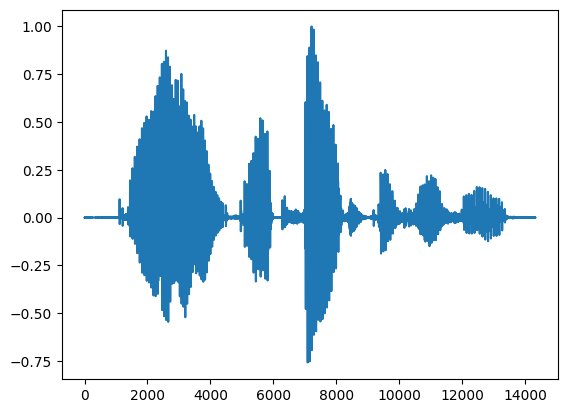

In [208]:
import matplotlib.pyplot as plt

plt.plot(x)

# LP Analysis

Summary of the main parts of LP analysis based on the autocorrelation criterion:
1. Select the order of prediction (p). As rule of thumb, p should be selected as the sampling frequency in kHz added by a small integer (Markel and Gray, 1976). For example, if signal is sampled with 8 kHz, a proper prediction order is p=10 or p=12.
2. Select a value for the frame length (N) and the window type. A good choice for N is a value that guarantees that there are a few fundamental cycles of voiced speech within the frame, yet not too many in order to keep the signal stationary. Hence, a typical window length is 20-30 ms which corresponds to 160-240 samples when fs=8 kHz. Windowing is recommended to be done with windows such as Hamming or Hann (i.e. not rectangular).
3. Window the signal to get N windowed samples into the frame.
4. Compute autocorrelation terms R(0)-R(p).
5. Solve matrix A. Due to the fact that the autocorrelation matrix in R is symmetric (= columns correspond to rows) and Toepliz (= same element in diagonals), matrix inversion can be computed with the Levison-Durbin recursion which is computationally efficient.
6. Form a digital FIR filter from the solved coefficients
7. Filter the original speech frame with A(z) to obtain the residual.

In [209]:
def windowing(signal, frame_length_ms, sampling_rate):
    """Windowing signal with no overlap"""
    frame_length = int(sampling_rate * frame_length_ms / 1000)
    window = np.hamming(frame_length)
    number_of_frames = int(np.ceil(len(signal) / frame_length))
    pad_amount = number_of_frames * frame_length - len(signal)
    padded_signal = np.pad(signal, ((0, pad_amount)))

    frame_matrix_orig = np.zeros((number_of_frames, frame_length))
    frame_matrix_windowed = np.zeros((number_of_frames, frame_length))
    for i in range(0, number_of_frames,):
        start_index = i * frame_length
        end_index = start_index + frame_length
        frame_matrix_orig[i, :] = padded_signal[start_index:end_index]
        frame_matrix_windowed[i, :] = np.multiply(padded_signal[start_index:end_index], window)

    return frame_matrix_orig, frame_matrix_windowed

In [210]:
frame_matrix_orig, frame_matrix_windowed = windowing(x, 25, fs)

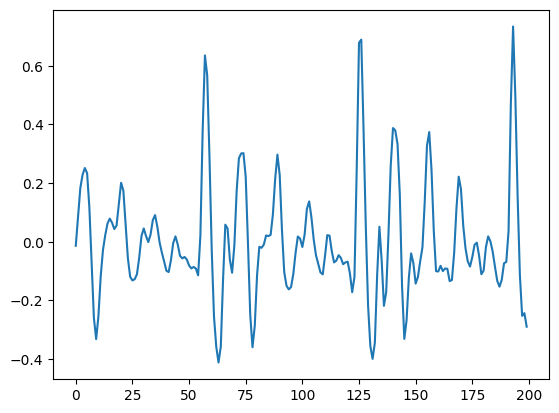

In [211]:
plt.plot(frame_matrix_orig[11, :])

In [212]:
frame_matrix_orig.shape

(72, 200)

In [213]:
def autocorrelation(frame, p):
    result = np.correlate(frame, frame, mode='full')
    mid = len(result) // 2
    result = result[mid:mid + p + 1]
    return result

In [214]:
corr_coef = autocorrelation(frame_matrix_windowed[0], p=10)

In [215]:
from scipy.linalg import solve_toeplitz

def solve_lpc_coefficient(corr_coef):
    # Construct toeplitz matrix
    corr_matrix = np.zeros((len(corr_coef) - 1, len(corr_coef) - 1))

    for i in range(corr_matrix.shape[0]):
        for j in range(corr_matrix.shape[1]):
            corr_matrix[i, j] = corr_coef[abs(i - j)]

    lpc_coef = solve_toeplitz((corr_matrix[0, :], corr_matrix[:, 0]), corr_coef[1:])
    # lpc_coef = np.linalg.solve(corr_matrix, corr_coef[1:])
    return lpc_coef

In [216]:
lpc_coef = solve_lpc_coefficient(corr_coef)

In [217]:
from scipy.signal import lfilter

def lpc_residual_frame(frame, lpc_coef, prev_samples):
    A = np.concatenate(([1.0], -lpc_coef))
    extended_input = np.concatenate((prev_samples, frame))
    residual_extended = lfilter(A, [1.0], extended_input)
    # Discard the first p samples of the output (they correspond to prev_samples)
    residual = residual_extended[len(prev_samples):]

    return residual

In [218]:

def lpc_analysis(signal, fs, p, frame_length_ms):
    """
    Perform LPC analysis on an entire signal (no frame overlap).

    Parameters
    ----------
    signal : 1D ndarray
        Input speech signal.
    fs : int
        Sampling frequency in Hz.
    p : int
        LPC order.
    frame_length_ms : float
        Frame length in milliseconds.

    Returns
    -------
    residual_frames : 2D ndarray [num_frames, frame_length]
        LPC residual per frame.
    lpc_coeffs : 2D ndarray [num_frames, p]
        LPC coefficients per frame.
    frame_matrix_orig : 2D ndarray
        Windowed frames without windowing function.
    frame_matrix_windowed : 2D ndarray
        Windowed frames used for LPC analysis.
    """
    frame_matrix_orig, frame_matrix_windowed = windowing(signal, frame_length_ms, fs)
    num_frames, _ = frame_matrix_windowed.shape

    residual_frames = np.zeros_like(frame_matrix_orig)
    lpc_coeffs = np.zeros((num_frames, p))

    # Initial previous samples: zeros for the very first frame
    prev_samples = np.zeros(p)

    for i in range(num_frames):
        win_frame = frame_matrix_windowed[i, :]
        orig_frame = frame_matrix_orig[i, :]
        r = autocorrelation(win_frame, p)
        a = solve_lpc_coefficient(r)
        lpc_coeffs[i, :] = a

        residual = lpc_residual_frame(orig_frame, a, prev_samples)
        residual_frames[i, :] = residual

        # Update previous samples for next frame (non-windowed)
        prev_samples = orig_frame[-p:]

    return residual_frames, lpc_coeffs


In [219]:
residual_frames, lpc_coeffs = lpc_analysis(x, fs, 10, 25)


In [220]:
residual_frames.shape

(72, 200)

In [221]:
lpc_coeffs.shape

(72, 10)

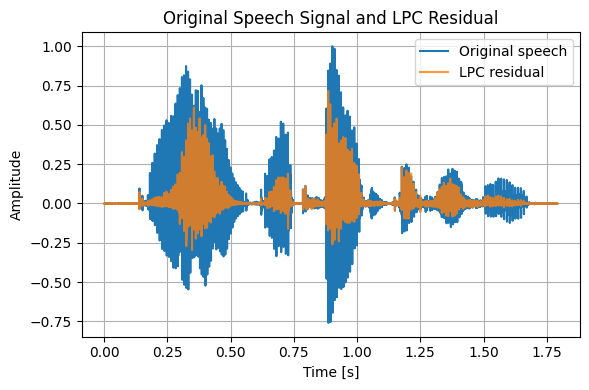

In [222]:
import numpy as np
import matplotlib.pyplot as plt


# 1) Flatten residual frames into a single long residual signal
residual_full = residual_frames.flatten()

# If your framing padded the signal to full frames, trim residual to match original length
residual_full = residual_full[:len(x)]

# 2) Create time axis in seconds for the entire signal
t = np.arange(len(x)) / fs

# 3) Plot original signal and residual on the same amplitude scale
plt.figure(figsize=(6, 4))

plt.plot(t, x, label='Original speech')
plt.plot(t, residual_full, label='LPC residual', alpha=0.8)

plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Original Speech Signal and LPC Residual')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


# LPC synthesis

In [223]:
from scipy.signal import lfilter, lfiltic

def lpc_synthesis(residual_frames, lpc_coeffs):
    """
    Perform LPC synthesis to reconstruct signal from residual.
    
    Parameters
    ----------
    residual_frames : 2D ndarray [num_frames, frame_length]
        LPC residual per frame from analysis stage.
    lpc_coeffs : 2D ndarray [num_frames, p]
        LPC coefficients per frame.
    delay_lines : 2D ndarray [num_frames, p]
        Initial conditions from analysis (NOT USED in synthesis).
    
    Returns
    -------
    reconstructed_signal : 1D ndarray
        Reconstructed speech signal.
    reconstructed_frames : 2D ndarray [num_frames, frame_length]
        Reconstructed signal organized by frames.
    """
    num_frames, frame_length = residual_frames.shape
    p = lpc_coeffs.shape[1]
    
    reconstructed_frames = np.zeros_like(residual_frames)
    
    # Initialize previous reconstructed samples
    prev_reconstructed_samples = np.zeros(p)
    
    for i in range(num_frames):
        a = lpc_coeffs[i, :]
        b = np.array([1.0])
        A = np.concatenate(([1.0], -a))
        residual = residual_frames[i, :]
        
        # Compute initial conditions from previous reconstructed samples (y[n-1], ..., y[n-p])
        # lfiltic expects: b, a, y_history (reversed)
        y_hist_reversed = prev_reconstructed_samples[::-1]
        zi = lfiltic(b, A, y_hist_reversed)
        
        reconstructed_frame, _ = lfilter(b, A, residual, zi=zi)        
        reconstructed_frames[i, :] = reconstructed_frame
        
        prev_reconstructed_samples = reconstructed_frame[-p:]
    
    reconstructed_signal = reconstructed_frames.flatten()    
    return reconstructed_signal, reconstructed_frames

In [224]:
reconstruted_signal, reconstructed_frames = lpc_synthesis(residual_frames, lpc_coeffs)

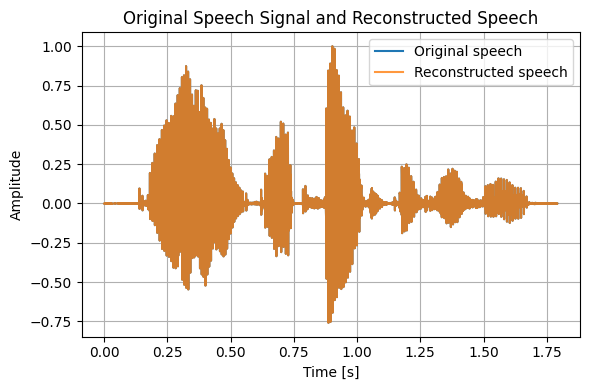

In [225]:
import numpy as np
import matplotlib.pyplot as plt

# 2) Create time axis in seconds for the entire signal
t = np.arange(len(x)) / fs

# 3) Plot original signal and residual on the same amplitude scale
plt.figure(figsize=(6, 4))

plt.plot(t, x, label='Original speech')
plt.plot(t, reconstruted_signal[:len(x)], label='Reconstructed speech', alpha=0.8)

plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Original Speech Signal and Reconstructed Speech')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


# Quantize

In [226]:
def lpc_to_reflection_coef(lpc_coef):
    p = len(lpc_coef)
    k = np.zeros(p)
    a = np.copy(lpc_coef)

    for i in range(p-1, -1, -1):
        k[i] = a[i]
        a_new = np.zeros(p)

        for m in range(0, i):
            a_new[m] = (a[m] + k[i] * a[i-m-1]) / (1 - k[i]**2)

        a = a_new
    return k

In [227]:
reflection_coef = lpc_to_reflection_coef(lpc_coef)

In [228]:
lpc_coef

array([ 0.10202833,  0.23948306,  0.14788884, -0.06825064,  0.20077633,
        0.11599069, -0.11598881,  0.05704982,  0.17256722,  0.00330672])

In [4]:
import numpy as np

# Your filter coefficients
h = np.array([0.10202833, 0.23948306, 0.14788884, -0.06825064, 0.20077633,
              0.11599069, -0.11598881, 0.05704982, 0.17256722, 0.00330672])

h = np.concatenate([[1], -h])

# Find the zeros of the filter
zeros = np.roots(h)

# Check if minimum phase (all zeros inside unit circle)
magnitudes = np.abs(zeros)
is_minimum_phase = np.all(magnitudes < 1.0)

print("Filter zeros:")
for i, z in enumerate(zeros):
    location = "inside" if np.abs(z) < 1.0 else "outside"
    print(f"Zero {i+1}: |z| = {np.abs(z):.4f} ({location} unit circle)")

print(f"\nIs minimum phase? {is_minimum_phase}")

Filter zeros:
Zero 1: |z| = 0.9654 (inside unit circle)
Zero 2: |z| = 0.7839 (inside unit circle)
Zero 3: |z| = 0.7839 (inside unit circle)
Zero 4: |z| = 0.8324 (inside unit circle)
Zero 5: |z| = 0.8324 (inside unit circle)
Zero 6: |z| = 0.8699 (inside unit circle)
Zero 7: |z| = 0.8699 (inside unit circle)
Zero 8: |z| = 0.7424 (inside unit circle)
Zero 9: |z| = 0.7424 (inside unit circle)
Zero 10: |z| = 0.0193 (inside unit circle)

Is minimum phase? True


In [229]:
reflection_coef

array([ 0.38966229,  0.36339825,  0.29246356,  0.01496769,  0.2161072 ,
        0.15748708, -0.06770984,  0.07791188,  0.17290649,  0.00330672])

In [230]:
def reflection_to_lpc_coef(reflection_coef):
    p = len(reflection_coef)
    a = np.zeros(p)
    k = np.copy(reflection_coef)

    for i in range(p):
        a_new = np.zeros(p)
        a_new[i] = k[i]
        for m in range(i):
            a_new[m] = a[m] - k[i] * a[i-1-m]

        a = a_new

    return a

In [231]:
reflection_to_lpc_coef(reflection_coef)

array([ 0.10202833,  0.23948306,  0.14788884, -0.06825064,  0.20077633,
        0.11599069, -0.11598881,  0.05704982,  0.17256722,  0.00330672])

In [232]:
def quantize_reflection_coefficients(reflection_coef, num_bits):
    num_levels = 2**num_bits
    reflection_coef_max = 1
    reflection_coef_min = -1
    
    # Quantization step size
    delta = (reflection_coef_max - reflection_coef_min) / num_levels
    
    # Quantize: map to nearest quantization level
    k_indices = np.floor((reflection_coef - reflection_coef_min) / delta)
    k_quantized = (k_indices + 0.5) * delta + reflection_coef_min
    
    return k_quantized

In [233]:
reflection_coef

array([ 0.38966229,  0.36339825,  0.29246356,  0.01496769,  0.2161072 ,
        0.15748708, -0.06770984,  0.07791188,  0.17290649,  0.00330672])

In [234]:
reflection_coef_quant = quantize_reflection_coefficients(reflection_coef, 3)

In [235]:
reflection_coef_quant

array([ 0.375,  0.375,  0.375,  0.125,  0.125,  0.125, -0.125,  0.125,
        0.125,  0.125])

In [236]:
lpc_coef_quant = reflection_to_lpc_coef(reflection_coef_quant)

In [237]:
lpc_coef

array([ 0.10202833,  0.23948306,  0.14788884, -0.06825064,  0.20077633,
        0.11599069, -0.11598881,  0.05704982,  0.17256722,  0.00330672])

In [238]:
lpc_coef_quant

array([ 0.015625  ,  0.19140625,  0.2903862 ,  0.09188658,  0.08138572,
        0.05319002, -0.1865921 ,  0.09335327,  0.12109375,  0.125     ])

In [239]:
from scipy.signal import freqz

def compute_spectral_distortion(lpc_unquant, lpc_quant, n_fft=1024):
    A_unquant = np.concatenate(([1.0], -lpc_unquant))
    A_quant = np.concatenate(([1.0], -lpc_quant))
    
    _, H_unquant = freqz([1.0], A_unquant, worN=n_fft, whole=False)
    _, H_quant = freqz([1.0], A_quant, worN=n_fft, whole=False)
    
    # Power Spectra
    P_unquant = np.abs(H_unquant)**2
    P_quant = np.abs(H_quant)**2
    
    log_P_unquant = 10 * np.log10(P_unquant)
    log_P_quant = 10 * np.log10(P_quant)
    
    squared_diff = (log_P_unquant - log_P_quant)**2
    sd_squared = 1 / (n_fft / 2 + 1) * np.sum(squared_diff[:n_fft // 2 + 1]) 
    sd = np.sqrt(sd_squared)

    return sd
    

In [240]:
compute_spectral_distortion(lpc_coef, lpc_coef_quant, 1024)

np.float64(1.5947610762656494)

In [241]:
def compute_average_sd_for_signal(lpc_coeffs_unquant, lpc_coeffs_quant, n_fft=1024):
    num_frames = lpc_coeffs_unquant.shape[0]
    sd_per_frame = np.zeros(num_frames)
    
    for i in range(num_frames):
        sd_per_frame[i] = compute_spectral_distortion(
            lpc_coeffs_unquant[i, :],
            lpc_coeffs_quant[i, :], 
            n_fft
        )
    
    avg_sd = np.mean(sd_per_frame)
    
    return avg_sd

In [242]:
def compute_sd_for_quantization_schemes(lpc_coeffs, num_bits_list=[5, 4, 3]):
    results = {}
    quantized_lpc = {}
    
    for num_bits in num_bits_list:
        num_frames, _ = lpc_coeffs.shape
        lpc_coeffs_quant = np.zeros_like(lpc_coeffs)
        
        for i in range(num_frames):
            reflection_coef = lpc_to_reflection_coef(lpc_coeffs[i, :])
            reflection_coef_quant = quantize_reflection_coefficients(reflection_coef, num_bits)
            lpc_coeffs_quant[i, :] = reflection_to_lpc_coef(reflection_coef_quant)
        
        avg_sd = compute_average_sd_for_signal(lpc_coeffs, lpc_coeffs_quant, n_fft=1024)
        
        results[num_bits] = avg_sd
        quantized_lpc[num_bits] = lpc_coeffs_quant
        
        print(f"{num_bits}-bit quantization: Average SD = {avg_sd:.4f} dB")
    
    return results, quantized_lpc

In [243]:
results, quantized_lpc = compute_sd_for_quantization_schemes(lpc_coeffs)

5-bit quantization: Average SD = 0.9751 dB
4-bit quantization: Average SD = 2.0400 dB
3-bit quantization: Average SD = 3.1897 dB


In [244]:
def plot_lattice_coefficients(lpc_coef_unquant, frame_idx, num_bits=3):
    """
    Plot original and quantized lattice filter coefficients for one frame.
    
    Parameters
    ----------
    lpc_coef_unquant : 1D ndarray of length p
        Unquantized LPC coefficients for the selected frame
    frame_idx : int
        Frame index (for title)
    num_bits : int
        Number of bits for quantization (default: 3)
    """
    # Convert to reflection coefficients (original)
    k_original = lpc_to_reflection_coef(lpc_coef_unquant)
    
    # Quantize
    k_quantized = quantize_reflection_coefficients(k_original, num_bits)
    
    p = len(k_original)
    stages = np.arange(1, p + 1)
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Plot both original and quantized coefficients
    plt.plot(stages, k_original, 'b-o', label='Original', linewidth=2, markersize=8)
    plt.plot(stages, k_quantized, 'r-s', label=f'{num_bits}-bit Quantized', linewidth=2, markersize=8)
    
    
    # Formatting
    plt.xlabel('Lattice Stage (i)', fontsize=12)
    plt.ylabel('Reflection Coefficient k_i', fontsize=12)
    plt.title(f'Lattice Filter Coefficients - Frame {frame_idx}', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.ylim([-1.1, 1.1])
    plt.xticks(stages)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nOriginal coefficients: {k_original}")
    print(f"Quantized coefficients: {k_quantized}")

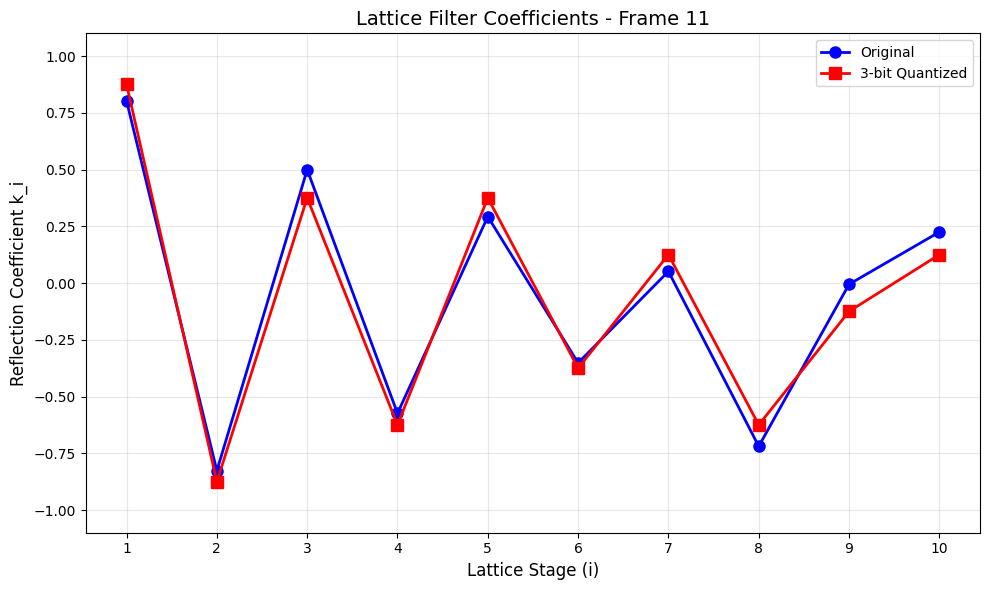


Original coefficients: [ 0.80222544 -0.82682724  0.49920602 -0.57397536  0.29259865 -0.35190106
  0.05127001 -0.71923252 -0.00554163  0.22484619]
Quantized coefficients: [ 0.875 -0.875  0.375 -0.625  0.375 -0.375  0.125 -0.625 -0.125  0.125]


In [245]:
plot_lattice_coefficients(lpc_coeffs[11, :], 11)

In [246]:

def lpc_analysis_quant(signal, fs, p, frame_length_ms):
    """
    Perform LPC analysis on an entire signal (no frame overlap).

    Parameters
    ----------
    signal : 1D ndarray
        Input speech signal.
    fs : int
        Sampling frequency in Hz.
    p : int
        LPC order.
    frame_length_ms : float
        Frame length in milliseconds.

    Returns
    -------
    residual_frames : 2D ndarray [num_frames, frame_length]
        LPC residual per frame.
    lpc_coeffs : 2D ndarray [num_frames, p]
        LPC coefficients per frame.
    frame_matrix_orig : 2D ndarray
        Windowed frames without windowing function.
    frame_matrix_windowed : 2D ndarray
        Windowed frames used for LPC analysis.
    """
    frame_matrix_orig, frame_matrix_windowed = windowing(signal, frame_length_ms, fs)
    num_frames, _ = frame_matrix_windowed.shape

    residual_frames = np.zeros_like(frame_matrix_orig)
    lpc_coeffs = np.zeros((num_frames, p))
    lpc_coeffs_quant = np.zeros((num_frames, p))

    # Initial previous samples: zeros for the very first frame
    prev_samples = np.zeros(p)

    for i in range(num_frames):
        win_frame = frame_matrix_windowed[i, :]
        orig_frame = frame_matrix_orig[i, :]
        r = autocorrelation(win_frame, p)
        a = solve_lpc_coefficient(r)
        lpc_coeffs[i, :] = a

        reflection_coef = lpc_to_reflection_coef(lpc_coef)
        reflection_coef_quant = quantize_reflection_coefficients(reflection_coef, 3)
        lpc_coef_quant = reflection_to_lpc_coef(reflection_coef_quant)
        lpc_coeffs_quant[i, :] = lpc_coef_quant

        residual = lpc_residual_frame(orig_frame, lpc_coef_quant, prev_samples)
        residual_frames[i, :] = residual

        # Update previous samples for next frame (non-windowed)
        prev_samples = orig_frame[-p:]

    return residual_frames, lpc_coeffs, lpc_coeffs_quant


In [247]:
residual_frames, lpc_coeffs, lpc_coeffs_quant = lpc_analysis_quant(x, fs, 10, 25)

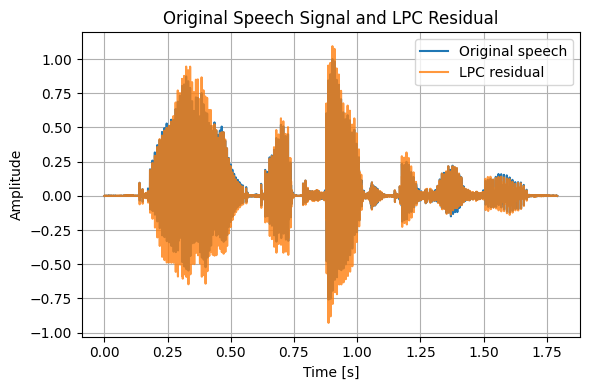

In [248]:
import numpy as np
import matplotlib.pyplot as plt


# 1) Flatten residual frames into a single long residual signal
residual_full = residual_frames.flatten()

# If your framing padded the signal to full frames, trim residual to match original length
residual_full = residual_full[:len(x)]

# 2) Create time axis in seconds for the entire signal
t = np.arange(len(x)) / fs

# 3) Plot original signal and residual on the same amplitude scale
plt.figure(figsize=(6, 4))

plt.plot(t, x, label='Original speech')
plt.plot(t, residual_full, label='LPC residual', alpha=0.8)

plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Original Speech Signal and LPC Residual')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [249]:
reconstruted_signal, reconstructed_frames = lpc_synthesis(residual_frames, lpc_coeffs_quant)

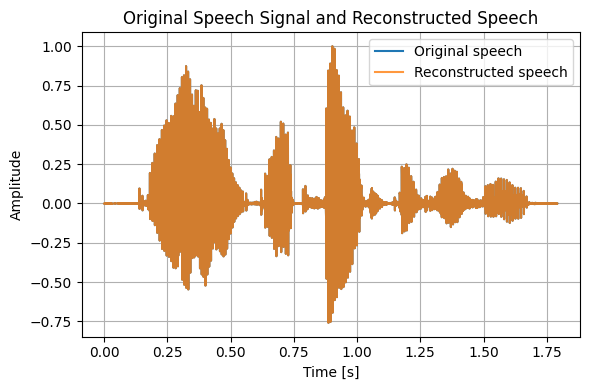

In [250]:
import numpy as np
import matplotlib.pyplot as plt

# 2) Create time axis in seconds for the entire signal
t = np.arange(len(x)) / fs

# 3) Plot original signal and residual on the same amplitude scale
plt.figure(figsize=(6, 4))

plt.plot(t, x, label='Original speech')
plt.plot(t, reconstruted_signal[:len(x)], label='Reconstructed speech', alpha=0.8)

plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Original Speech Signal and Reconstructed Speech')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()
